In [1]:
import psycopg2
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import dotenv
import numpy as np

In [2]:
dotenv.load_dotenv('.env', override=True)

True

In [3]:
# Connect to DB
conn = psycopg2.connect(
    f"dbname='{os.environ['POSTGRES_DB']}' user='{os.environ['POSTGRES_USER']}' "
    f"host='{os.environ['POSTGRES_HOST']}' password='{os.environ['POSTGRES_PASSWORD']}'"
)

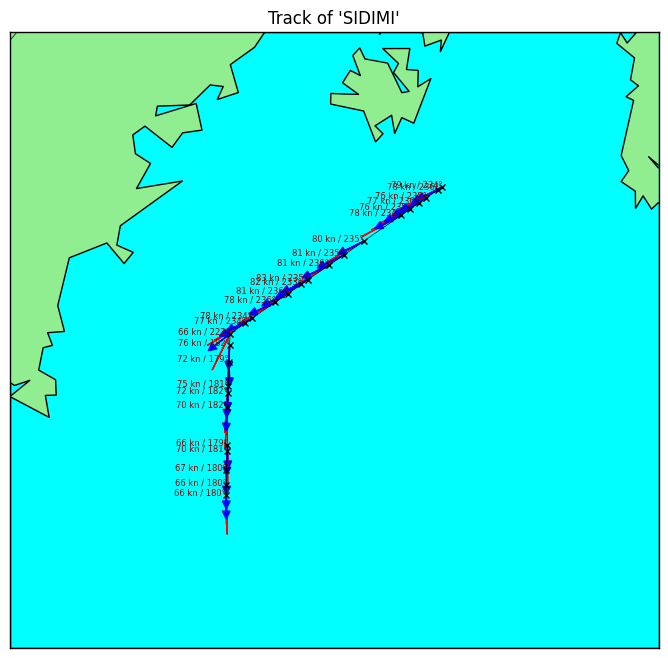

In [144]:

def showTrackOfShip(ship_name, scale=1, show_info=True, show_nav=True):
    # Get ship data
    with conn.cursor() as cursor:
        cursor.execute(f"""
            SELECT location[0] AS latitude, location[1] AS longitude, speed, course, heading
            FROM positions
            WHERE ship_id = (SELECT id FROM ships WHERE ships.name LIKE '{ship_name}' LIMIT 1)
            ORDER BY added_date
        """)
        data = cursor.fetchall()

    # Get coords & other info
    lats, lons, speeds, courses, heading = zip(*data)

    # Scale range (margins)
    lat_margin = (max(lats) - min(lats)) * scale
    lon_margin = (max(lons) - min(lons)) * scale * 2

    # Calc scale factors
    lat_size = (max(lats) + lat_margin) - (min(lats) - lat_margin)
    lon_size = (max(lons) + lon_margin) - (min(lons) - lon_margin)

    # Render landscape
    plt.figure(figsize=(10, 8))
    m = Basemap(projection='merc',
                llcrnrlat=min(lats) - lat_margin, urcrnrlat=max(lats) + lat_margin,
                llcrnrlon=min(lons) - lon_margin, urcrnrlon=max(lons) + lon_margin,
                resolution='i')
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgreen', lake_color='aqua')

    x, y = m(lons, lats)
    # Render ships
    for i in range(len(x)):
        baseLengthX = 4000 * lon_size
        baseLengthY = 4000 * lat_size

        # Show info
        if show_info:
            plt.text(x[i], y[i], f'{speeds[i]} kn / {courses[i]}°',
                    fontsize=6, color='darkred', ha='right')

        if show_nav:
            # Show heading
            dx = baseLengthX * np.cos(np.radians(-heading[i] + 90))
            dy = baseLengthY * np.sin(np.radians(-heading[i] + 90))
            plt.arrow(x[i], y[i], dx, dy, head_width=0,
                    head_length=baseLengthX, fc='red', ec='red')

            # Show course
            dx = baseLengthX * np.cos(np.radians(-courses[i] + 90))
            dy = baseLengthY * np.sin(np.radians(-courses[i] + 90))
            plt.arrow(x[i], y[i], dx, dy, head_width=baseLengthX / 3,
                    head_length=baseLengthX / 3, fc='blue', ec='blue')

    # Render path
    m.plot(x, y, marker='x', markersize=5, linewidth=0.5, color='black')

    plt.title(f"Track of '{ship_name}'")
    plt.show()


showTrackOfShip('SIDIMI', 0.5)

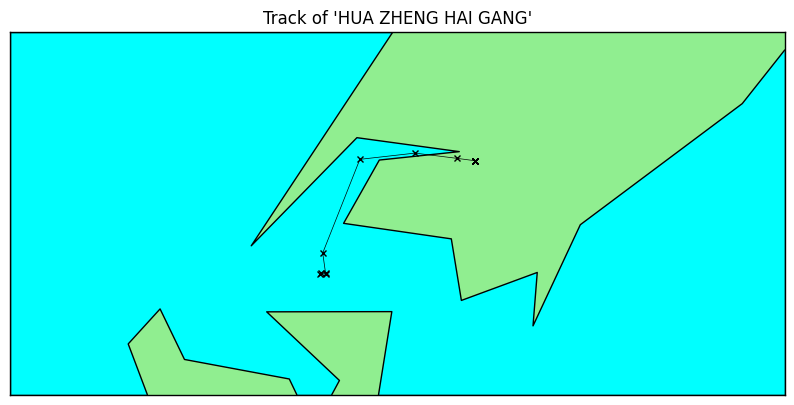

In [146]:
showTrackOfShip('HUA ZHENG HAI GANG', 1, show_info=False, show_nav=False)

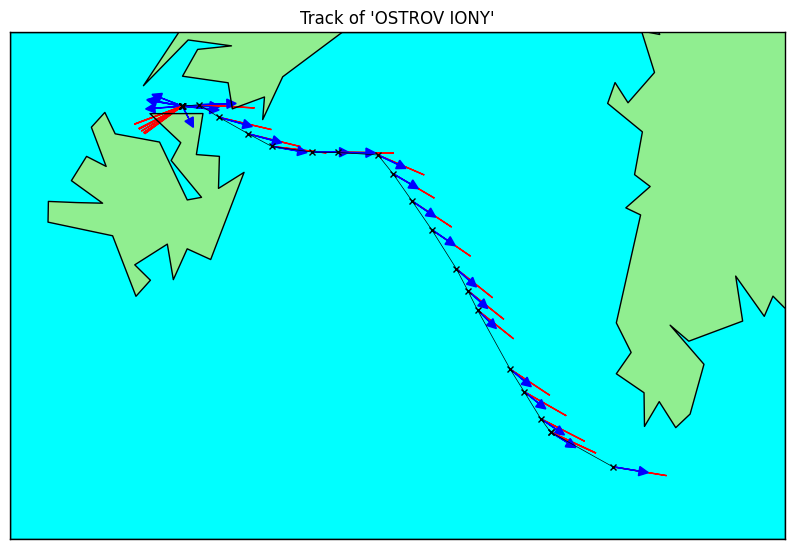

In [157]:
showTrackOfShip('OSTROV IONY', 0.2, show_info=False, show_nav=True)

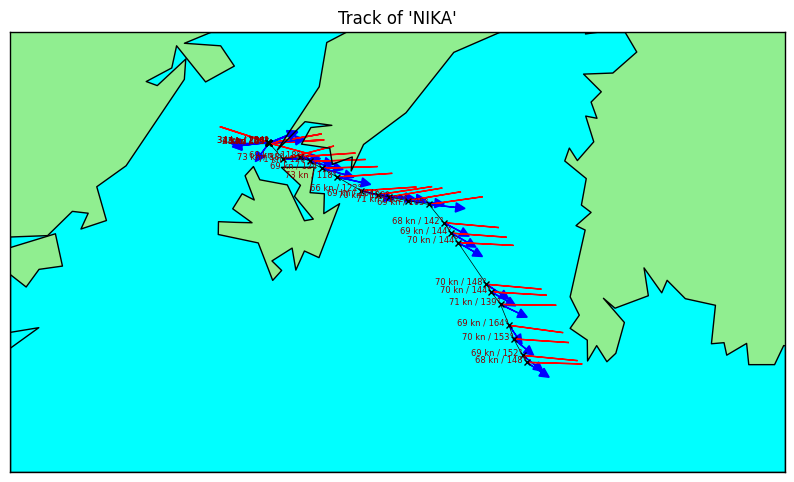

In [163]:
showTrackOfShip('NIKA', 0.5)

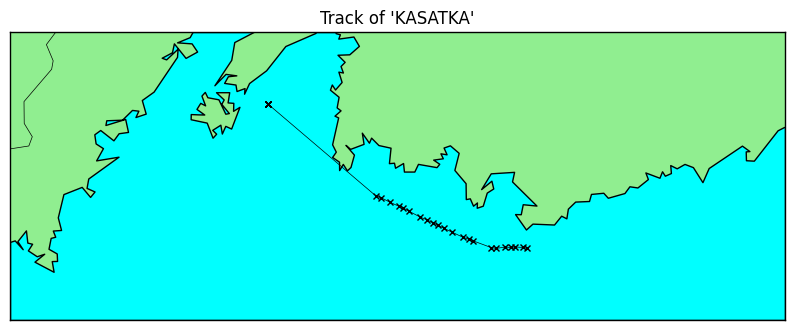

In [166]:
showTrackOfShip('KASATKA', 0.5, show_info=False, show_nav=False)